# <font color=orange> <center>CSCI 5901 - Process of Data Science - Assignment 2 </center>

### <font color=purple> <center> Team Members </center></font>
### <font color=purple> <center> Lan Chen (B00809814, lan.chen@dal.ca), Jamuna Loganath (B00811590, jamuna.loganath@dal.ca)</center>

## <font color=blue> Q1. Collocation extraction. ( 35 marks )

### a. Tokenize this corpus and perform part-of-speech tagging on it. ( 5 marks )

 * <font color=#008000> Before tokenizing the corpus, preprocessing has to be done to clean and massage the dataset to fetch appropriate and meaningful results. 

In [17]:
# importing necessary libraries
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk import pos_tag_sents

from nltk.collocations import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# these are the four categories which we are using to train our model.
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
print("Loading 20 newsgroups dataset for categories :")
print("The categories are :",categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("There are %d number of documents from four categories" % len(data.filenames))
print("There are %d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories :
The categories are : ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
There are 2034 number of documents from four categories
There are 4 categories



 * <font color=#008000> Viewing the data_format in document

In [19]:
df = pd.DataFrame({'text': data.data,'target':data.target})
df.head()

,text,target
0,From: rych@festival.ed.ac.uk (R Hawkes)\nSubje...,1
1,Subject: Re: Biblical Backing of Koresh's 3-02...,3
2,From: Mark.Perew@p201.f208.n103.z1.fidonet.org...,2
3,From: dpw@sei.cmu.edu (David Wood)\nSubject: R...,0
4,From: prb@access.digex.com (Pat)\nSubject: Con...,2


In [20]:
df.shape

(2034, 2)

In [21]:
df.target.value_counts()

2    593
1    584
0    480
3    377
Name: target, dtype: int64

 * <font color=#008000> Basic Preprocessing 

#### Step by step preprocessing

In [22]:
text = df.text.iloc[1]
print(text) # we can see the raw text of a single document

Subject: Re: Biblical Backing of Koresh's 3-02 Tape (Cites enclosed)
From: kmcvay@oneb.almanac.bc.ca (Ken Mcvay)
Organization: The Old Frog's Almanac
Lines: 20

In article <20APR199301460499@utarlg.uta.edu> b645zaw@utarlg.uta.edu (stephen) writes:

>Seems to me Koresh is yet another messenger that got killed
>for the message he carried. (Which says nothing about the 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.

>In the mean time, we sure learned a lot about evil and corruption.
>Are you surprised things have gotten that rotten?

Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
-- 
The Old Frog's Almanac - A Salute to That Old Frog Hisse'f, Ryugen Fisher 
     (604) 245-3205 (v32) (604) 245-4366 (2400x4) SCO XENIX 2.3.2 GT 
  Ladysmith, British Columbia, CA

In [23]:
# Strip first block corresponding to email details
def stripheaders(text):
    dirt = text.split("\n\n")[0] # locate headers as everything before first double newline and save as string
    strip = text.replace(dirt, '') # Strip that string from full text
    return strip
stepbystep = stripheaders(text)
print(stepbystep)



In article <20APR199301460499@utarlg.uta.edu> b645zaw@utarlg.uta.edu (stephen) writes:

>Seems to me Koresh is yet another messenger that got killed
>for the message he carried. (Which says nothing about the 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.

>In the mean time, we sure learned a lot about evil and corruption.
>Are you surprised things have gotten that rotten?

Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
-- 
The Old Frog's Almanac - A Salute to That Old Frog Hisse'f, Ryugen Fisher 
     (604) 245-3205 (v32) (604) 245-4366 (2400x4) SCO XENIX 2.3.2 GT 
  Ladysmith, British Columbia, CANADA. Serving Central Vancouver Island  
with public access UseNet and Internet Mail - home to the Holocaust Almanac



In [24]:
# Strip lines containing "@" (usually emails)
def stripcontains (text):
    strip = "\n".join([line for line in text.splitlines() if not "@" in line])
    return strip
stepbystep = stripcontains(stepbystep)
print(stepbystep)




>Seems to me Koresh is yet another messenger that got killed
>for the message he carried. (Which says nothing about the 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.

>In the mean time, we sure learned a lot about evil and corruption.
>Are you surprised things have gotten that rotten?

Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
-- 
The Old Frog's Almanac - A Salute to That Old Frog Hisse'f, Ryugen Fisher 
     (604) 245-3205 (v32) (604) 245-4366 (2400x4) SCO XENIX 2.3.2 GT 
  Ladysmith, British Columbia, CANADA. Serving Central Vancouver Island  
with public access UseNet and Internet Mail - home to the Holocaust Almanac


In [25]:
# Lowercase and remove punctuation 
import string
exclude = set(string.punctuation) # special characters stored in a variable.
print('The special characters we are going to exclude from document are :\n',exclude)
def low_punc (text): 
    nopunc = ''.join(ch for ch in text.lower() if ch not in exclude) 
    result = ''.join([i for i in nopunc if not i.isdigit()])   # removingt numbers
    new_string = ' '.join([w for w in result.split() if len(w)>2]) # removing words with length less than two
    return new_string
stepbystep = low_punc(stepbystep)
print('\n Preprocessed Text :\n *********************\n',stepbystep)

The special characters we are going to exclude from document are :
 {'^', ']', '=', '@', '~', ')', '*', '(', "'", '%', ',', '"', '$', '#', '_', '/', '`', '[', '-', '.', '&', ':', '!', '{', '<', '\\', '}', ';', '+', '?', '|', '>'}

 Preprocessed Text :
 *********************
 seems koresh yet another messenger that got killed for the message carried which says nothing about the seems barring evidence the contrary that koresh was simply another deranged fanatic who thought neccessary take whole bunch folks with him children and all satisfy his delusional mania jim jones circa the mean time sure learned lot about evil and corruption are you surprised things have gotten that rotten nope fruitcakes like koresh have been demonstrating such evil corruption for centuries the old frogs almanac salute that old frog hissef ryugen fisher sco xenix ladysmith british columbia canada serving central vancouver island with public access usenet and internet mail home the holocaust almanac


#### Applying the basic preprocessing for all the documents.

In [26]:
# method to clean with basic preprocessing and apply for the total text data
exclude = set(string.punctuation)  # we have used above this again we are using here just if in case you dont want to run above cells
def clean(text):
    # locate headers before first double new line
    dirt = text.split("\n\n")[0] 
    
    # Remove headers
    stripheaders = text.replace(dirt, '')
    
    # Remove line containing email addresses
    stripline = "\n".join([line for line in stripheaders.splitlines() if not "@" in line]) 
    
    # Remove punctuation and numbers
    char = ''.join(ch for ch in stripline if ch not in exclude) 
    result = ''.join([i for i in char if not i.isdigit()])
    
    # remove words with lenght less than 2
    clean_text = ' '.join([w for w in result.split() if len(w)>2]) 
    
    return clean_text

 * <font color=#008000> Preprocessing is successfully completed. Now, tokenization and parts of speech tagging are done on the cleaned data.

In [27]:
# Tokenizing the text by calling 'clean' method for preprocessing

clean_doc = [clean(doc).split() for doc in df.text]   
print(clean_doc[1])

['Seems', 'Koresh', 'yet', 'another', 'messenger', 'that', 'got', 'killed', 'for', 'the', 'message', 'carried', 'Which', 'says', 'nothing', 'about', 'the', 'Seems', 'barring', 'evidence', 'the', 'contrary', 'that', 'Koresh', 'was', 'simply', 'another', 'deranged', 'fanatic', 'who', 'thought', 'neccessary', 'take', 'whole', 'bunch', 'folks', 'with', 'him', 'children', 'and', 'all', 'satisfy', 'his', 'delusional', 'mania', 'Jim', 'Jones', 'circa', 'the', 'mean', 'time', 'sure', 'learned', 'lot', 'about', 'evil', 'and', 'corruption', 'Are', 'you', 'surprised', 'things', 'have', 'gotten', 'that', 'rotten', 'Nope', 'fruitcakes', 'like', 'Koresh', 'have', 'been', 'demonstrating', 'such', 'evil', 'corruption', 'for', 'centuries', 'The', 'Old', 'Frogs', 'Almanac', 'Salute', 'That', 'Old', 'Frog', 'Hissef', 'Ryugen', 'Fisher', 'SCO', 'XENIX', 'Ladysmith', 'British', 'Columbia', 'CANADA', 'Serving', 'Central', 'Vancouver', 'Island', 'with', 'public', 'access', 'UseNet', 'and', 'Internet', 'Mail'

In [28]:
def flatten(list):  #Appending all the words in to a single list
    new_list = []
    for i in list:
        for j in i:
            new_list.append(j)
    return new_list

In [29]:
total_words = flatten(clean_doc) # function call to flatten method
print('The total number of words from all documents are :',len(total_words))

The total number of words from all documents are : 403474


In [30]:
# Parts-of-speech tagging

tagged = nltk.pos_tag(total_words) 
tagged[:10]

[('Ive', 'NNP'),
 ('noticed', 'VBD'),
 ('that', 'IN'),
 ('you', 'PRP'),
 ('only', 'RB'),
 ('save', 'VB'),
 ('model', 'NN'),
 ('with', 'IN'),
 ('all', 'DT'),
 ('your', 'PRP$')]

In [31]:
type(tagged)

list

### b. Apply the techniques described in Tutorial 6 (Frequency with filter, PMI, T-test with filter, Chi-Sq test) to extract bigram collocations from the corpus. Show the top 20 results of each technique. ( 15 marks )

In [32]:
bigrams = nltk.collocations.BigramAssocMeasures()

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(total_words)


### Frequency_count

In [33]:
#bigrams
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)



In [34]:
bigramFreqTable[:5]

,bigram,freq
278,"(that, the)",836
70,"(for, the)",741
1752,"(and, the)",684
543,"(from, the)",535
1014,"(with, the)",510


In [35]:
#get english stopwords
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english'))
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
filtered_bi[:5]

,bigram,freq
6462,"(dont, think)",133
7319,"(Jesus, Christ)",60
6086,"(moral, system)",54
3272,"(many, people)",53
21158,"(space, station)",50


In [36]:
bigramFinder.apply_freq_filter(20)
freq_bi = filtered_bi[:20].bigram.values
freq_bi

array([('dont', 'think'), ('Jesus', 'Christ'), ('moral', 'system'),
       ('many', 'people'), ('space', 'station'),
       ('objective', 'morality'), ('anonymous', 'FTP'),
       ('image', 'processing'), ('Thanks', 'advance'),
       ('Space', 'Shuttle'), ('David', 'Koresh'), ('United', 'States'),
       ('Cheers', 'Kent'), ('New', 'York'), ('dont', 'see'),
       ('existence', 'God'), ('New', 'Testament'), ('Jet', 'Propulsion'),
       ('source', 'code'), ('Computer', 'Graphics')], dtype=object)

### PMI

In [45]:
bigramFinder.apply_freq_filter(20)

bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)


In [46]:
bigramPMITable[:5]

,bigram,PMI
0,"(comme, aucun)",14.300188
1,"(fait, comme)",14.098554
2,"(sank, Manhattan)",14.031440
3,"(xxxx, xxxx)",13.911623
4,"(Virtual, Reality)",13.492833


In [47]:
pmi_bi = bigramPMITable[:20].bigram.values
pmi_bi

array([('comme', 'aucun'), ('fait', 'comme'), ('sank', 'Manhattan'),
       ('xxxx', 'xxxx'), ('Virtual', 'Reality'), ('McDonnell', 'Douglas'),
       ('Mary', 'Shafer'), ('Jet', 'Propulsion'), ('Air', 'Force'),
       ('Lab', 'Telos'), ('San', 'Jose'), ('remote', 'sensing'),
       ('United', 'States'), ('Thu', 'Apr'), ('Brian', 'Kendig'),
       ('Cheers', 'Kent'), ('Apr', 'GMT'), ('Old', 'Testament'),
       ('Propulsion', 'Lab'), ('black', 'holes')], dtype=object)

### T-test

In [48]:
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)
bigramTtable.head()

,bigram,t
0,"(the, same)",18.597028
1,"(from, the)",18.016236
2,"(does, not)",17.721909
3,"(have, been)",17.448182
4,"(for, the)",17.434522


In [49]:
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]
filteredT_bi[:5]

,bigram,t
27,"(dont, think)",11.324563
89,"(Jesus, Christ)",7.721989
105,"(moral, system)",7.303491
124,"(many, people)",7.065599
125,"(space, station)",7.054299


In [50]:
t_bi = filteredT_bi[:20].bigram.values
t_bi

array([('dont', 'think'), ('Jesus', 'Christ'), ('moral', 'system'),
       ('many', 'people'), ('space', 'station'),
       ('objective', 'morality'), ('anonymous', 'FTP'),
       ('Thanks', 'advance'), ('image', 'processing'),
       ('David', 'Koresh'), ('Space', 'Shuttle'), ('United', 'States'),
       ('Cheers', 'Kent'), ('New', 'York'), ('existence', 'God'),
       ('New', 'Testament'), ('dont', 'see'), ('Jet', 'Propulsion'),
       ('source', 'code'), ('Computer', 'Graphics')], dtype=object)

### Chi-Square

In [51]:
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.head()

,bigram,chi-sq
0,"(comme, aucun)",403474.000000
1,"(sank, Manhattan)",351641.555187
2,"(fait, comme)",350844.347697
3,"(xxxx, xxxx)",339026.569236
4,"(Jet, Propulsion)",266370.103538


In [52]:
chi_bi = bigramChiTable[:20].bigram.values
chi_bi

array([('comme', 'aucun'), ('sank', 'Manhattan'), ('fait', 'comme'),
       ('xxxx', 'xxxx'), ('Jet', 'Propulsion'), ('United', 'States'),
       ('McDonnell', 'Douglas'), ('remote', 'sensing'),
       ('Virtual', 'Reality'), ('Air', 'Force'), ('Cheers', 'Kent'),
       ('Mary', 'Shafer'), ('Lab', 'Telos'), ('San', 'Jose'),
       ('Apr', 'GMT'), ('Thu', 'Apr'), ('Old', 'Testament'),
       ('Brian', 'Kendig'), ('New', 'York'), ('Propulsion', 'Lab')],
      dtype=object)

* <font color=#008000> Thus the four techniques are implemented successfully and the top 20 results are displayed.

### c. How much overlap is there among the techniques? Do you think it makes sense to consider the union of the results? ( 15 marks )

* <font color=#008000> Comparison of the four techniques

In [53]:
bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, t_bi, chi_bi]).T
bigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test']
bigramsCompare

,Frequency With Filter,PMI,T-test With Filter,Chi-Sq Test
0,"(dont, think)","(comme, aucun)","(dont, think)","(comme, aucun)"
1,"(Jesus, Christ)","(fait, comme)","(Jesus, Christ)","(sank, Manhattan)"
2,"(moral, system)","(sank, Manhattan)","(moral, system)","(fait, comme)"
3,"(many, people)","(xxxx, xxxx)","(many, people)","(xxxx, xxxx)"
4,"(space, station)","(Virtual, Reality)","(space, station)","(Jet, Propulsion)"
5,"(objective, morality)","(McDonnell, Douglas)","(objective, morality)","(United, States)"
6,"(anonymous, FTP)","(Mary, Shafer)","(anonymous, FTP)","(McDonnell, Douglas)"
7,"(image, processing)","(Jet, Propulsion)","(Thanks, advance)","(remote, sensing)"
8,"(Thanks, advance)","(Air, Force)","(image, processing)","(Virtual, Reality)"
9,"(Space, Shuttle)","(Lab, Telos)","(David, Koresh)","(Air, Force)"


* <font color=#008000>Comparing the results of the four techniques, we found that Frequency with Filter method and T-test with Filter produce almost the same result. The order of the result was little different but the same. On the other hand, PMI and Chi-Square methods produce around 50% of the same result. Here too the order of the words differ. 
* <font color=#008000> In our opinion it would be a great idea to union the results of the four techniques together to get all possible bigrams in an effective way.  

### Q2. SVM and NB for Text Classification (75 marks) In this part, you will play around with SVM and Naive Bayes for text classification on the corpus of Q1.

<font color=#008000>a. Clean the text: ( 10 marks )
 * <font color=#008000>  Remove stop words
 * <font color=#008000>  Remove numbers and other non-letter characters
 * <font color=#008000> Stem the words

In [54]:
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')

# method for removing stopwords, 
def some_more_clean(text):
    #first preprocess call(remove numbers, special_characters, unnecessary lines)
    clean_text = clean(text) 
    
    # lower case and Remove stop words
    text_rmstop = " ".join([i for i in clean_text.lower().split() if i not in stop])
    
    # Lemmatize : getting the root word
    lemmatized = " ".join(lemma.lemmatize(word) for word in text_rmstop.split()) 
    
    # Stemming : removing suffix and prefixes
    cleaned_text = ' '.join(sno.stem(t) for t in lemmatized.split())
    
    return cleaned_text

In [55]:
cleaned_doc = [some_more_clean(doc).split() for doc in df.text]   
len(cleaned_doc)


2034

### b. Study the section on feature extraction in Scikit Learn, https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction and convert the corpus into a bag-of-words tf-idf weighted vector representation. ( 10 marks )

In [56]:
# joining the words which are splitted in to sentences
clean_doc_list=[]
for i in cleaned_doc:
    new_doc = ' '.join(i)
    clean_doc_list.append(new_doc)
len(clean_doc_list)


2034

### Bag of Words Count Vectorizers

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(clean_doc_list)
X_train_counts.shape


(2034, 202303)

### TF-IDF Vectorizer

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer().fit(X_train_counts)  # fit
X_train_tf = tf_transformer.transform(X_train_counts)    # transform
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)   # fit and transform in single step
X_train_tf.shape

(2034, 202303)

In [59]:
X_train_tf

<2034x202303 sparse matrix of type '<class 'numpy.float64'>'
	with 428463 stored elements in Compressed Sparse Row format>

### Question 2 c
#### Split the data randomly into training and testing set (70-30 %). (​5 marks​) 

In [60]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train_tf,data.target,test_size=0.3,random_state=302)

#### Train SVM and report confusion matrix. (​5 marks​) 

In [61]:
from sklearn import svm

In [62]:
text_clf_svm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
text_clf_svm.fit(X_train, y_train)  
pre_svm = text_clf_svm.predict(X_test)
cm_svm = metrics.confusion_matrix(y_test,pre_svm)

In [63]:
# plot confusion matrix
# refer to https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, categories, rotation=60)
    plt.yticks(tick_marks, categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


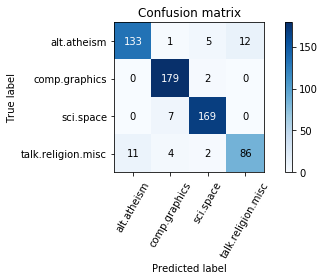

In [64]:
from sklearn import metrics
plot_confusion_matrix(cm_svm)

In [65]:
print(round(metrics.accuracy_score(y_test,pre_svm),2))

0.93


#### Train Multinomial NB and report confusion matrix. (​5 marks​) 

In [66]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [67]:
y_pred = clf.predict(X_test)

In [68]:
cm_nb = metrics.confusion_matrix(y_test,y_pred)

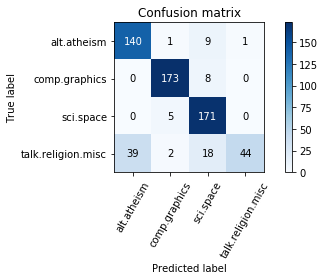

In [69]:
plot_confusion_matrix(cm_nb)

In [70]:
print(round(metrics.accuracy_score(y_test,y_pred),2))


0.86


#### Which algorithm has higher accuracy and why? (​5 marks​) 

 * <font color=#008000> The accuary of SVM is 0.93, while it's 0.86 for Multinomial NB algorithm. So SVM has higher accuracy on this task. It's because the data structure and data size of this task more suitable for SVM model than Multinomial NB algorithm.

#### Does changing the kernel of the SVM change the accuracy or decrease confusion between classes? (​15 marks​) 

In [71]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [72]:
gs_clf = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train) 

C:\Users\lanch\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [73]:
gs_clf.best_params_

{'kernel': 'linear'}

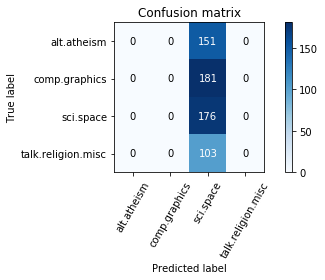

In [74]:
# try the rbf kernel to verify the performance on svm
text_clf_svm_rbf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
text_clf_svm_rbf.fit(X_train, y_train)  

pre_svm_rbf = text_clf_svm_rbf.predict(X_test)
cm_rbf = metrics.confusion_matrix(y_test,pre_svm_rbf)

plot_confusion_matrix(cm_rbf)

In [75]:
# print acuarcy score of SVM with kernel 'rbf'
print(round(metrics.accuracy_score(y_test,pre_svm_rbf),2))

0.29


 * <font color=#008000> When we changed the kernel from 'linear' to 'rbf', the model performed very bad, the accuracy score is only 0.29. The accuracy of the model decreased and only recognized the targets of 'sci.space'

### d. Perform part-of-speech tagging on the raw data (i.e. prior to cleaning it), clean as in part (a) above, and extract the nouns only to obtain a bag-of-words tf-idf weighted vector representation using only the nouns. Repeat question (c). How does this accuracy compare with that of part (c)? How does the size of the vocabulary compare with that of part (c)? (​20 marks​) 

####  Perform part-of-speech tagging on the raw data (i.e. prior to cleaning it)

In [76]:
#raw data check
df.head(5)

,text,target
0,From: rych@festival.ed.ac.uk (R Hawkes)\nSubje...,1
1,Subject: Re: Biblical Backing of Koresh's 3-02...,3
2,From: Mark.Perew@p201.f208.n103.z1.fidonet.org...,2
3,From: dpw@sei.cmu.edu (David Wood)\nSubject: R...,0
4,From: prb@access.digex.com (Pat)\nSubject: Con...,2


In [77]:
# tokenize the raw data
df['text'] = df['text'].apply(word_tokenize)

In [78]:
df.head(5)

,text,target
0,"[From, :, rych, @, festival.ed.ac.uk, (, R, Ha...",1
1,"[Subject, :, Re, :, Biblical, Backing, of, Kor...",3
2,"[From, :, Mark.Perew, @, p201.f208.n103.z1.fid...",2
3,"[From, :, dpw, @, sei.cmu.edu, (, David, Wood,...",0
4,"[From, :, prb, @, access.digex.com, (, Pat, ),...",2


In [79]:
# apply part of speech to raw data and save on the 'pos' column
df['pos'] = df['text'].apply(pos_tag)

In [80]:
df.head(5)

,text,target,pos
0,"[From, :, rych, @, festival.ed.ac.uk, (, R, Ha...",1,"[(From, IN), (:, :), (rych, NN), (@, NN), (fes..."
1,"[Subject, :, Re, :, Biblical, Backing, of, Kor...",3,"[(Subject, JJ), (:, :), (Re, NN), (:, :), (Bib..."
2,"[From, :, Mark.Perew, @, p201.f208.n103.z1.fid...",2,"[(From, IN), (:, :), (Mark.Perew, NNP), (@, NN..."
3,"[From, :, dpw, @, sei.cmu.edu, (, David, Wood,...",0,"[(From, IN), (:, :), (dpw, NN), (@, NN), (sei...."
4,"[From, :, prb, @, access.digex.com, (, Pat, ),...",2,"[(From, IN), (:, :), (prb, NN), (@, NN), (acce..."


### clean as in part (a) above

### ● Remove stop words ● Remove numbers and other non-letter characters ● Stem the words 

In [81]:
# function for removing stop words
def remove_stopwords (l):
    clean_list = []
    for word in l:
        if word.lower() not in stopwords.words('english'):
            clean_list.append(word)
    return clean_list
            

In [82]:
# remove stop words
df['text'] =df['text'].apply(remove_stopwords)

In [83]:
#function for removing numbers and other non-letter characters 

def remove_no_punctuation (l):
    clean_list = []
    for word in l:
        if not word.isdigit():
            if word not in string.punctuation:
                clean_list.append(word)
    return clean_list


In [84]:
# remove numbers and other non-letter characters 
df['text'] =df['text'].apply(remove_no_punctuation)

In [85]:
df.head(5)

,text,target,pos
0,"[rych, festival.ed.ac.uk, R, Hawkes, Subject, ...",1,"[(From, IN), (:, :), (rych, NN), (@, NN), (fes..."
1,"[Subject, Biblical, Backing, Koresh, 's, 3-02,...",3,"[(Subject, JJ), (:, :), (Re, NN), (:, :), (Bib..."
2,"[Mark.Perew, p201.f208.n103.z1.fidonet.org, Su...",2,"[(From, IN), (:, :), (Mark.Perew, NNP), (@, NN..."
3,"[dpw, sei.cmu.edu, David, Wood, Subject, Reque...",0,"[(From, IN), (:, :), (dpw, NN), (@, NN), (sei...."
4,"[prb, access.digex.com, Pat, Subject, Conferen...",2,"[(From, IN), (:, :), (prb, NN), (@, NN), (acce..."


In [86]:
#update 'pos' column
for index,row in df.iterrows():
    clean_list=[]
    for word_pos in row['pos']:
        if word_pos[0] in row['text']:
            clean_list.append(word_pos)  
    df.at[index,'pos'] = clean_list
       

In [87]:
#return only noun
noun = ['NN','NNS','NNP','NNPS']
def nouns (l):
    new_list = []
    for word_tag in l:
        if word_tag[1] in noun:
            new_list.append(word_tag)
    return new_list

In [88]:
df['pos'] = df['pos'].apply(nouns)

In [89]:
df.head(5)

,text,target,pos
0,"[rych, festival.ed.ac.uk, R, Hawkes, Subject, ...",1,"[(rych, NN), (festival.ed.ac.uk, NN), (R, NNP)..."
1,"[Subject, Biblical, Backing, Koresh, 's, 3-02,...",3,"[(Backing, NNP), (Koresh, NNP), (Tape, NN), (C..."
2,"[Mark.Perew, p201.f208.n103.z1.fidonet.org, Su...",2,"[(Mark.Perew, NNP), (p201.f208.n103.z1.fidonet..."
3,"[dpw, sei.cmu.edu, David, Wood, Subject, Reque...",0,"[(dpw, NN), (sei.cmu.edu, NN), (David, NNP), (..."
4,"[prb, access.digex.com, Pat, Subject, Conferen...",2,"[(prb, NN), (access.digex.com, NN), (Pat, NNP)..."


In [90]:
#update to the result to text which only extract nouns
for index,row in df.iterrows():
    noun_list=[]
    for word_pos in row['pos']:
        noun_list.append(word_pos[0]) 
             
    df.at[index,'text'] = noun_list

In [91]:
df.head(5)

,text,target,pos
0,"[rych, festival.ed.ac.uk, R, Hawkes, Subject, ...",1,"[(rych, NN), (festival.ed.ac.uk, NN), (R, NNP)..."
1,"[Backing, Koresh, Tape, Cites, kmcvay, oneb.al...",3,"[(Backing, NNP), (Koresh, NNP), (Tape, NN), (C..."
2,"[Mark.Perew, p201.f208.n103.z1.fidonet.org, Su...",2,"[(Mark.Perew, NNP), (p201.f208.n103.z1.fidonet..."
3,"[dpw, sei.cmu.edu, David, Wood, Subject, Reque...",0,"[(dpw, NN), (sei.cmu.edu, NN), (David, NNP), (..."
4,"[prb, access.digex.com, Pat, Subject, Conferen...",2,"[(prb, NN), (access.digex.com, NN), (Pat, NNP)..."


In [92]:
# Stem the words 
def stem_word (l):
    stem_list =[]
    for word in l:
        stem_list.append(sno.stem(word))
    return stem_list

In [93]:
df['text'] = df['text'].apply(stem_word)

In [94]:
# join the text for bag of word
df['text_join'] = df['text'].apply(lambda x: ' '.join(x))

In [95]:
df.head(5)

,text,target,pos,text_join
0,"[rych, festival.ed.ac.uk, r, hawk, subject, te...",1,"[(rych, NN), (festival.ed.ac.uk, NN), (R, NNP)...",rych festival.ed.ac.uk r hawk subject textur r...
1,"[back, koresh, tape, cite, kmcvay, oneb.almana...",3,"[(Backing, NNP), (Koresh, NNP), (Tape, NN), (C...",back koresh tape cite kmcvay oneb.almanac.bc.c...
2,"[mark.perew, p201.f208.n103.z1.fidonet.org, su...",2,"[(Mark.Perew, NNP), (p201.f208.n103.z1.fidonet...",mark.perew p201.f208.n103.z1.fidonet.org subje...
3,"[dpw, sei.cmu.edu, david, wood, subject, reque...",0,"[(dpw, NN), (sei.cmu.edu, NN), (David, NNP), (...",dpw sei.cmu.edu david wood subject request sup...
4,"[prb, access.digex.com, pat, subject, confer, ...",2,"[(prb, NN), (access.digex.com, NN), (Pat, NNP)...",prb access.digex.com pat subject confer man lu...


### obtain a bag-of-words tf-idf weighted vector representation using only the nouns

In [96]:
cv = CountVectorizer()

In [97]:
bow = cv.fit_transform(df['text_join'])

In [98]:
print(bow.shape)

(2034, 19799)


In [99]:
tfidf = TfidfTransformer().fit_transform(bow)

#### Repeat question (c). 

In [100]:
X = tfidf
y = df['target']

In [101]:
#Split the data randomly into training and testing set (70-30 %) 

In [102]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=302)

In [103]:
#Train SVM and report confusion matrix. 

In [104]:
svm_noun = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

In [105]:
svm_noun.fit(X_train,y_train)
pre_noun = svm_noun.predict(X_test)

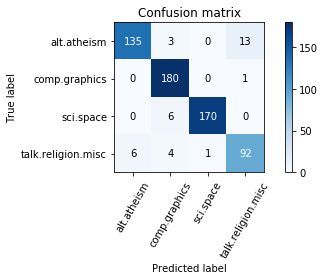

In [106]:
svm_cm=metrics.confusion_matrix(y_test,pre_noun)
plot_confusion_matrix(svm_cm)

In [107]:
# report accuracy score
print(round(metrics.accuracy_score(y_test,pre_noun),2))


0.94


<font color=#008000> For SVM model, the accuracy was improved to 0.94 from 0.93 by only applying nouns for the text classification. The size of the vocabulary which only included nouns is 19799, while the other one is 202303. The size of previous one is about 10 times larger than the one only with nouns.

In [108]:
#Train Multinomial NB and report confusion matrix 

In [109]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
pre_noun_nb = nb.predict(X_test)

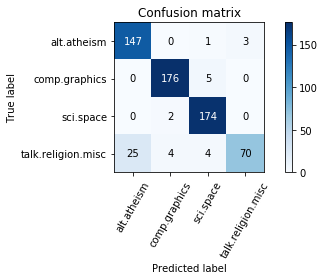

In [110]:
nb_cm =metrics.confusion_matrix(y_test,pre_noun_nb)
plot_confusion_matrix(nb_cm)

In [111]:
# report accuracy score
print(round(metrics.accuracy_score(y_test,pre_noun_nb),2))

0.93


<font color=#008000> For Multinomial model, the accuracy was improved to 0.93 from 0.86 by only applying nouns for the text classification.

### References

 * [1] Python, T., Ninja, H. and Bram, W. (2019). Tokenize words in a list of sentences Python. [online] Stack Overflow. Available at: https://stackoverflow.com/questions/21361073/tokenize-words-in-a-list-of-sentences-python [Accessed 9 Jul. 2019].
 * [2] Nltk.org. (2019). Collocations. [online] Available at: http://www.nltk.org/howto/collocations.html [Accessed 9 Jul. 2019].
 * [3] Medium. (2019). Collocations — identifying phrases that act like single words in Natural Language Processing. [online] Available at: https://medium.com/@nicharuch/collocations-identifying-phrases-that-act-like-individual-words-in-nlp-f58a93a2f84a [Accessed 9 Jul. 2019].
 * [4] Users.umiacs.umd.edu. (2019). Assignment 2. [online] Available at: http://users.umiacs.umd.edu/~resnik/ling773_sp2018/assignments/assignment2.html [Accessed 9 Jul. 2019].
 * [5] "Confusion matrix — scikit-learn 0.21.2 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. [Accessed: 16- Jul- 2019].